In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 13:43:44.226292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 13:43:45.732405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 19170
end_idx = 19240
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(70, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(70, 96, 7)
(47040,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(70, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(70, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 13:43:54.879501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:85:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 13:43:57.762352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step
CPU time: 1952.5099711329676 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

3/3 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.08292285 0.07547711 0.5945104  ... 0.28981042 0.10901875 0.08825867]
Fitness value of the best solution = 0.3024859842342209


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

3/3 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


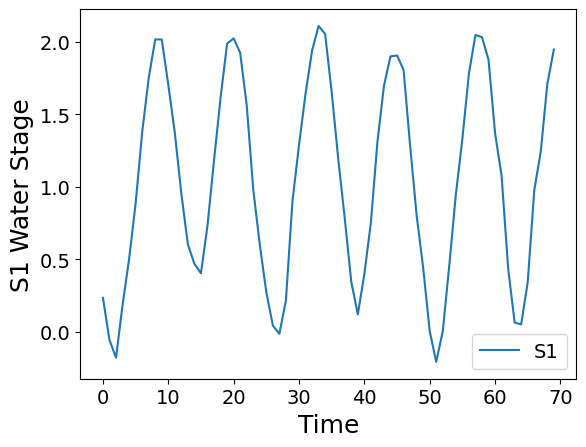

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low22.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.082923,0.075477,0.594510,0.318947,0.600003,0.611732,0.311248,0.495113,0.816135,0.931467,...,0.521476,0.469971,0.867830,0.387033,0.765397,0.416154,0.205573,0.639177,0.987348,0.435888
1,0.534958,0.824705,0.222723,0.225082,0.117288,0.809786,0.301819,0.010915,0.898321,0.706167,...,0.748855,0.456118,0.507413,0.946110,0.286937,0.095949,0.891989,0.987858,0.349491,0.566118
2,0.590249,0.805119,0.579893,0.395397,0.500550,0.051874,0.194076,0.083905,0.257449,0.064001,...,0.529261,0.925206,0.597400,0.144154,0.504922,0.719387,0.821965,0.213556,0.125441,0.269881
3,0.333823,0.313202,0.522267,0.068014,0.701693,0.772602,0.421979,0.551553,0.079526,0.875837,...,0.051807,0.223754,0.698907,0.114299,0.935398,0.789837,0.729052,0.001036,0.053365,0.598472
4,0.977955,0.592572,0.319386,0.552492,0.004945,0.549443,0.418868,0.691389,0.972661,0.685136,...,0.869327,0.116668,0.416412,0.415238,0.019132,0.771773,0.877277,0.987746,0.056554,0.092813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.070724,0.296778,0.245423,0.297148,0.291194,0.587549,0.056723,0.936794,0.118828,0.319049,...,0.991407,0.686928,0.992656,0.258496,0.516933,0.964119,0.780795,0.793205,0.959441,0.801500
66,0.423211,0.199507,0.581127,0.997358,0.187211,0.853787,0.607760,0.426618,0.418036,0.604339,...,0.010937,0.547658,0.969489,0.409588,0.988673,0.361067,0.415434,0.546986,0.303227,0.195438
67,0.165765,0.438149,0.761920,0.478536,0.038546,0.473386,0.184807,0.732860,0.281184,0.125741,...,0.659106,0.977780,0.764566,0.990659,0.001165,0.513197,0.912326,0.873822,0.052458,0.796612
68,0.203832,0.648050,0.345805,0.237374,0.834528,0.700991,0.519915,0.903405,0.105765,0.904213,...,0.853369,0.068898,0.209418,0.410501,0.779572,0.784528,0.707583,0.433855,0.341128,0.888194


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low22.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.235092,0.212667,0.395974,0.255243,-0.060524,0.156941,0.108793,-0.031038,-0.101541,0.136878,...,1.924738,2.071809,1.491919,1.431666,1.602418,1.679125,1.082409,1.176366,1.284537,1.290477
1,-0.056003,-0.121593,0.077177,-0.073240,-0.054353,-0.207362,0.099856,-0.074173,0.121845,0.044253,...,1.502570,1.604856,1.106593,1.209134,1.272014,1.267579,0.651109,0.953355,0.864788,0.852086
2,-0.176660,-0.039031,-0.058190,-0.181579,0.162281,0.123915,0.249374,0.191596,0.571566,0.288598,...,1.236691,1.227990,0.699423,0.722608,0.879113,0.821687,0.286784,0.259701,0.549394,0.425424
3,0.184677,0.292787,0.269921,0.158417,0.534659,0.359219,0.626976,0.534657,1.023058,0.769884,...,0.844344,0.699068,0.288544,0.415221,0.485316,0.367539,0.105487,0.136849,0.403015,0.196052
4,0.502391,0.623686,0.614746,0.604294,0.907598,0.831298,0.903605,0.982425,1.389637,1.111709,...,0.596672,0.464726,0.064791,0.497770,0.323526,0.265335,0.185827,0.314995,0.362951,0.351643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.342345,0.592782,0.464683,0.350896,0.869056,0.931563,0.990123,0.855509,1.392824,1.480304,...,1.172909,1.075497,0.627572,0.661047,0.883154,0.812700,0.337069,0.401179,0.622280,0.494352
66,0.976026,0.711808,1.019359,1.005485,1.336801,1.261098,1.329461,1.340930,1.726392,1.709283,...,0.526376,0.478937,0.294005,0.307438,0.444811,0.408069,0.237270,0.316436,0.350410,0.361021
67,1.244329,1.593458,1.167523,1.234656,1.793186,1.827117,1.680861,1.782880,1.974140,2.046973,...,0.463086,0.287419,0.378793,0.755503,0.565993,0.495952,0.582534,0.949214,0.713740,0.666778
68,1.709912,1.931460,1.753970,1.763735,1.938068,1.903718,1.872019,1.956529,2.023316,2.054723,...,0.514030,0.351603,0.544401,0.553397,0.742452,0.689021,1.091569,1.066014,1.270812,1.255568


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 185, areas: 15.132329548796406


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

3/3 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 820, areas: 124.84569397536688
